In [1]:
import py4cytoscape as p4c
import pandas as pd
from sklearn.metrics import roc_curve
from typing import List, Dict, Iterable

import json
import requests

from net2rank.utils import process_train_file, H5Loader

p4c.cytoscape_ping()
p4c.cytoscape_version_info()

# use your preferred Cytoscape style; comment out if not needed
p4c.import_visual_styles('../data/Revelen_style.xml')

You are connected to Cytoscape!


['Revelen']

## Functions

In [2]:
def make_network(proteins:Iterable[str],
                 network_name:str,
                 cutoff:float=0.7,
                 species:str='Homo sapiens',
                 networktype='full STRING network') -> str:            
    protein_string = ','.join(proteins)
    command = (f'string protein query '
            f'query="{protein_string}" '
            f'species="{species}" '
            f'cutoff="{cutoff}" '
            f'networkType="{networktype}" '
            f'limit="0" '
            f'newNetName="{network_name}" ')
    suid = p4c.commands_post(command)
    return suid

def network_cluster(suid, inflation_parameter=4):
    cluster_cmd = (f'cluster mcl '
            f'network="{suid}" '
            f'inflation_parameter="{inflation_parameter}"')
    cluster_result = p4c.commands_post(cluster_cmd)  
    return cluster_result

def function_enrichment(proteins):
    string_api_url = "https://version-12-0.string-db.org/api"
    output_format = "json"
    method = "enrichment"

    request_url = "/".join([string_api_url, output_format, method])

    params = {

        "identifiers" : "%0d".join(proteins), # your protein
        "species" : 9606, # NCBI/STRING taxon identifier 
        "caller_identity" : "net2rank" # your app name
    }

    response = requests.post(request_url, data=params)

    data = json.loads(response.text)
    
    return data

def parse_enrichment_results(enrichment_results:List,category=None) -> pd.DataFrame:
    result = list()
    
    for row in enrichment_results:
        if float(row["fdr"]) > 0.05:
            continue
        
        if category is not None and row["category"] != category:
            continue

        result.append({
            'term': row['term'],
            'description': row["description"],
            'fdr': float(row["fdr"]),
            'num_genes': row['number_of_genes'],
            'num_genes_background': row['number_of_genes_in_background'],
            
            'category': row["category"],
        })
    df = pd.DataFrame(result)
    df = df.sort_values(by='fdr')
    
    return df

def select_proteins_by_enrichment(df:pd.DataFrame, term:str, category:str='Process') -> List[str]:
    """
    Select proteins by enrichment term and category.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing enrichment results.
    term : str
        The term to filter by.
    category : str
        The category to filter by (default is 'Process').
        
    Returns
    -------
    List[str]
        List of proteins associated with the specified term and category.
    """
    filtered_df = df[(df['term'] == term) & (df['category'] == category)]
    
    if filtered_df.empty:
        return []
    
    return filtered_df['num_genes'].tolist()

def load_protein_data(predictions_file:str,
                      train_file:str,
                      train_file_type:str,
                      pos_size:int=1000,
                      human_network_emb:str='../data/9606.node2vec64.h5',
                      threshold:float=0.05,
                      ) -> pd.DataFrame:

    df_predictions = pd.read_csv(predictions_file, sep='\t')
    fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
    threshold = thresholds[fpr <= 0.05][-1]
    df_predictions = df_predictions[df_predictions['predicted_score'] >= threshold]
    # protein_list = df_predictions[df_predictions['predicted_score'] >= threshold]['protein'].unique()

    protein_space = H5Loader(human_network_emb).proteins

    # train_file = '../data/train/atopic_dermatitis.integrated.tsv'
    # train_file_type = 'pvalue'
    # pos_size = 1000
    df_train = process_train_file(train_file, train_file_type, protein_space,pos_size)

    df_protein_category = list()

    for idx, row in df_predictions.iterrows():
        
        protein = row['protein']
        text_mining = True if row['true_label'] == 1 else False
        
        protein_in_training = df_train[df_train['protein'] == protein] ## all the proteins in the training set
        # Check if the protein is in the training set and has a class of 1
        if not protein_in_training.empty and protein_in_training['class'].values[0] == 1:
            training = True
        else:
            training = False
        
        df_protein_category.append({
            'protein': protein,
            'text_mining': text_mining,
            'training': training
        })
    df_protein_category = pd.DataFrame(df_protein_category)

    categories = list()
    for idx, row in df_protein_category.iterrows():
        if row['text_mining'] and row['training']:
            categories.append('both')
        elif row['text_mining'] and not row['training']:
            categories.append('text_mining')
        elif not row['text_mining'] and row['training']:
            categories.append('omics')
        else:
            categories.append('novel')
    df_protein_category['category'] = categories
    df_protein_category = df_protein_category.merge(df_predictions[['protein', 'predicted_score', 'true_label']], on='protein', how='left')
    
    return df_protein_category

def make_network_plot(df_protein_category:pd.DataFrame, enrichment_results:List[Dict],selected_term:str,
                      disease_name:str,cutoff:float=0.7,networktype:str='full STRING network') -> str:

    # start making the module network plot
    df_enrichment = parse_enrichment_results(enrichment_results)
    process_name = df_enrichment[df_enrichment['term'] == selected_term]['description'].values[0]

    for row in enrichment_results:
        if row['category'] == 'Process' and row['term'] == selected_term:
            selected_proteins = row['inputGenes']
            break
        
    suid = make_network(
        proteins=selected_proteins,
        network_name=f'{disease_name}_module_network_{process_name}',
        cutoff=cutoff,
        networktype=networktype)

    # Get the proteins that are in the 'both' category for pie chart logic
    both_proteins = df_protein_category[df_protein_category['category'] == 'both']['protein'].values
    
    pie_data = []
    for node in selected_proteins:
        if node in both_proteins:
            # For novel candidates, create pie chart data (e.g., 50% each category)
            pie_data.append({'name': node, 'value1': 50, 'value2': 50})
        else:
            # For other nodes, set to 0 so they don't show pie charts
            pie_data.append({'name': node, 'value1': 0, 'value2': 0})

    pie_df = pd.DataFrame(pie_data)

    p4c.set_visual_style('Revelen',network=suid)

    # Pass a copy of the DataFrame to avoid SettingWithCopyWarning
    p4c.load_table_data(df_protein_category.copy(), data_key_column='protein', table='node')
    p4c.set_node_color_mapping(
        table_column='category',
        table_column_values=['text_mining', 'training', 'novel'],
        colors=['#fa6600', '#27a59b', '#d8d8d8'],
        mapping_type='d',
        style_name='Revelen',
        network=suid
    )

    # Set up the pie chart with start angle from top (270 degrees or -90 degrees)
    p4c.load_table_data(pie_df.copy(), data_key_column='name', table='node')
    p4c.set_node_custom_pie_chart(
        columns=['value1', 'value2'], 
        colors=['#fa6600', '#27a59b'],  # Orange and teal
        slot=1, 
        style_name='Revelen',
        start_angle=270  # This sets the start position to the top (12 o'clock)
    )
    return suid



## Analysis

## atopic dermatitis

In [15]:
df_protein_category = pd.read_csv('../results/test_results/atopic_dermatitis/atopic_dermatitis_whole_prediction_results.tsv', sep='\t')
# sort by predicted score and take top 200
df_protein_category = df_protein_category.sort_values(by='predicted_score', ascending=False).iloc[:200, :]


# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='atopic_dermatitis_main_network',
    cutoff=0.7)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [16]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0031424,Keratinization,3.500000e-36,18,83,Process
1,GO:0008544,Epidermis development,1.380000e-29,19,320,Process


In [17]:
parse_enrichment_results(enrichment_results[1],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0060326,Cell chemotaxis,8.150000e-28,16,210,Process
1,GO:0030595,Leukocyte chemotaxis,4.090000e-27,15,149,Process
2,GO:0030593,Neutrophil chemotaxis,6.910000e-25,13,80,Process
3,GO:0070098,Chemokine-mediated signaling pathway,6.910000e-25,13,82,Process
4,GO:0097529,Myeloid leukocyte migration,6.910000e-25,14,138,Process
5,GO:0048247,Lymphocyte chemotaxis,3.050000e-19,10,51,Process
6,GO:0002548,Monocyte chemotaxis,2.630000e-17,9,43,Process
7,GO:0061844,Antimicrobial humoral immune response mediated...,3.560000e-16,10,113,Process
8,GO:0098542,Defense response to other organism,3.950000e-16,15,989,Process
9,GO:0034341,Response to interferon-gamma,9.500000e-16,10,127,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


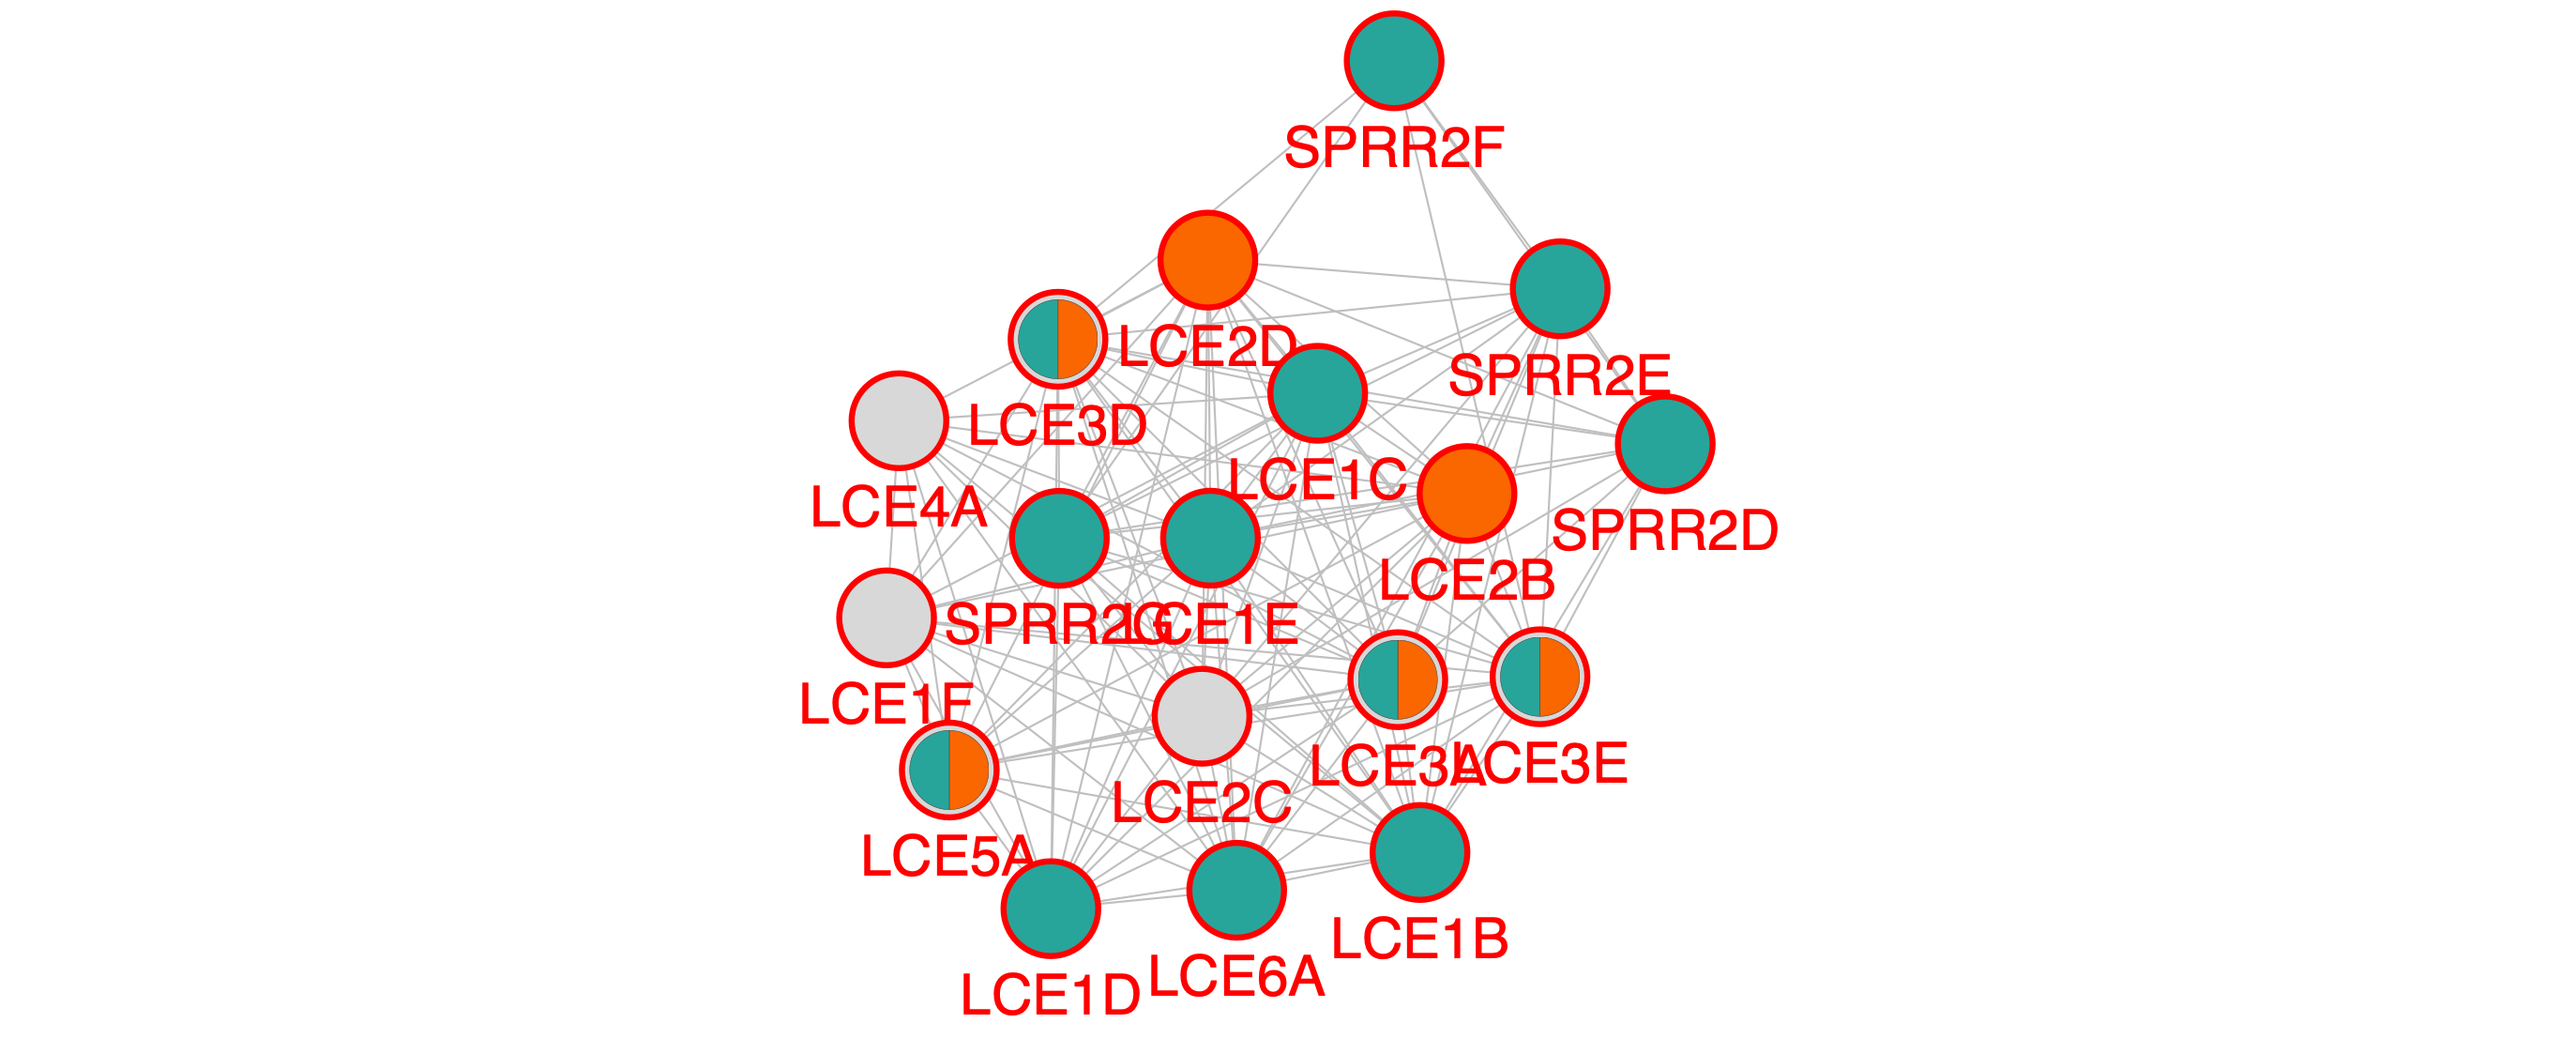

In [18]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0031424', # Keratinization
    disease_name='atopic_dermatitis',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


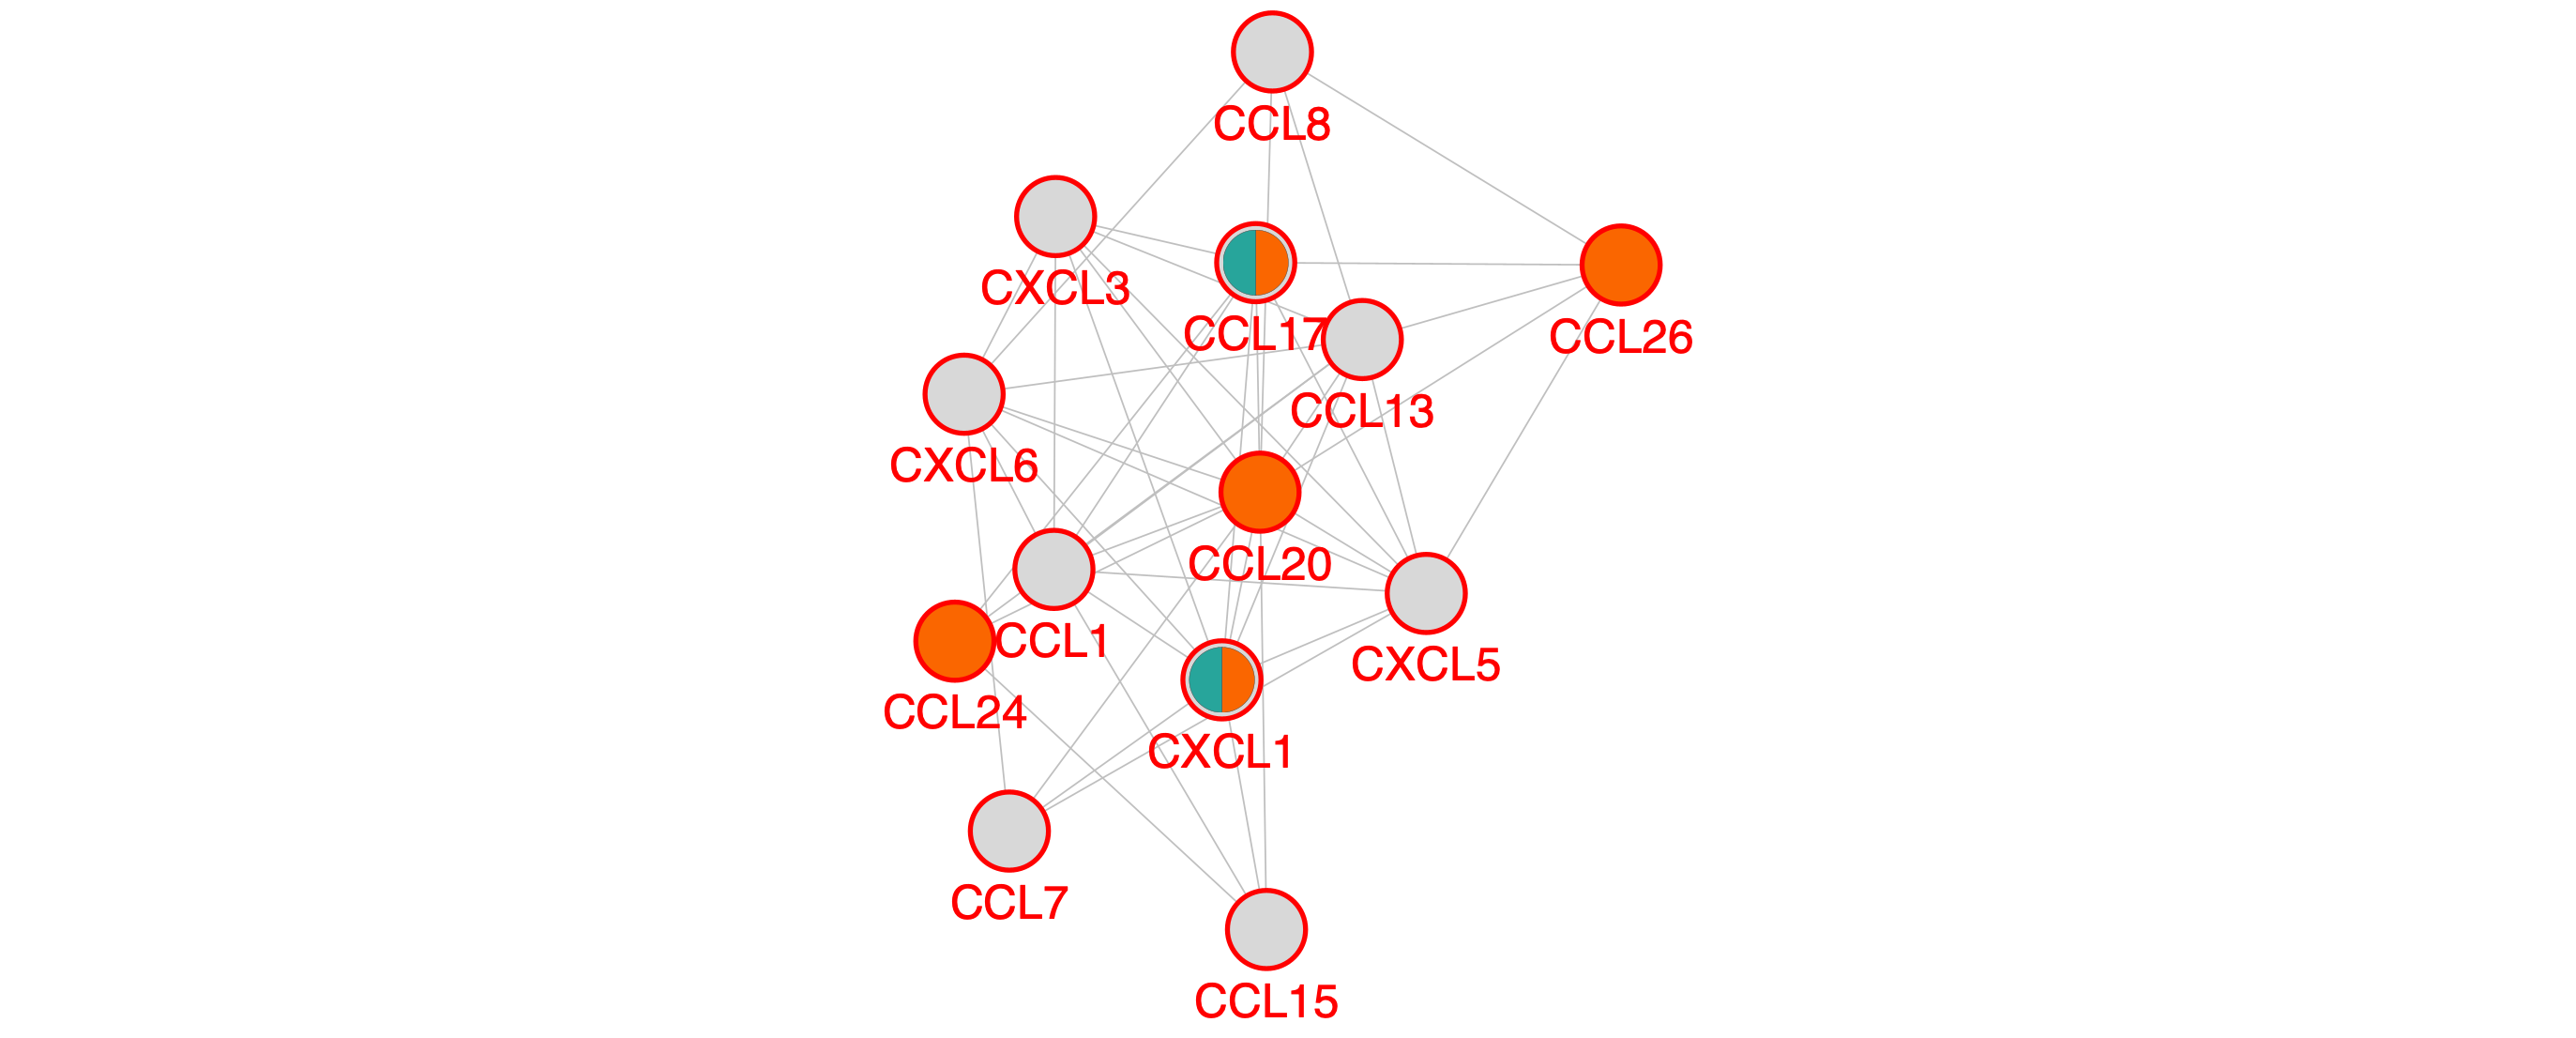

In [19]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[1],
    selected_term='GO:0070098', # Chemokine-mediated signaling pathway
    disease_name='atopic_dermatitis',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## Focal epiplepsy

In [58]:
df_protein_category = pd.read_csv('../results/test_results/focal_epilepsy/focal_epilepsy_whole_prediction_results.tsv', sep='\t').sort_values(by='predicted_score', ascending=False).iloc[:500, :]
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='focal_epilepsy_main_network',
    cutoff=0.4)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [59]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0006955,Immune response,2.400000e-19,27,1321,Process
1,GO:0002376,Immune system process,1.150000e-15,28,2121,Process
2,GO:0006952,Defense response,2.190000e-12,22,1394,Process
3,GO:0009607,Response to biotic stimulus,5.730000e-08,18,1375,Process
4,GO:0002682,Regulation of immune system process,9.570000e-08,18,1438,Process
5,GO:0044419,Biological process involved in interspecies in...,1.430000e-07,18,1490,Process
6,GO:0045087,Innate immune response,1.480000e-07,14,754,Process
7,GO:0051707,Response to other organism,1.910000e-07,17,1328,Process
8,GO:0098542,Defense response to other organism,2.870000e-07,15,989,Process
9,GO:0006954,Inflammatory response,3.880000e-07,12,538,Process


In [60]:
df_protein_category

,protein,predicted_score,category
12848,9606.ENSP00000376553,0.655270,training
6617,9606.ENSP00000322273,0.539468,novel
10951,9606.ENSP00000362205,0.490651,training
18434,9606.ENSP00000484060,0.461513,training
16982,9606.ENSP00000451712,0.426736,novel
...,...,...,...
82,9606.ENSP00000046794,0.223637,novel
6852,9606.ENSP00000325663,0.223405,novel
17022,9606.ENSP00000452786,0.223320,novel
4262,9606.ENSP00000293441,0.223126,training


In [51]:
parse_enrichment_results(enrichment_results[1],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0006955,Immune response,0.000002,10,1321,Process
1,GO:0098883,Synapse pruning,0.000002,4,11,Process
2,GO:0002252,Immune effector process,0.000003,7,375,Process
3,GO:0001774,Microglial cell activation,0.000013,4,31,Process
4,GO:0002684,Positive regulation of immune system process,0.000015,8,874,Process
5,GO:0006952,Defense response,0.000015,9,1394,Process
6,GO:0009607,Response to biotic stimulus,0.000015,9,1375,Process
7,GO:0002682,Regulation of immune system process,0.000016,9,1438,Process
8,GO:0098542,Defense response to other organism,0.000019,8,989,Process
9,GO:0002274,Myeloid leukocyte activation,0.000022,5,150,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


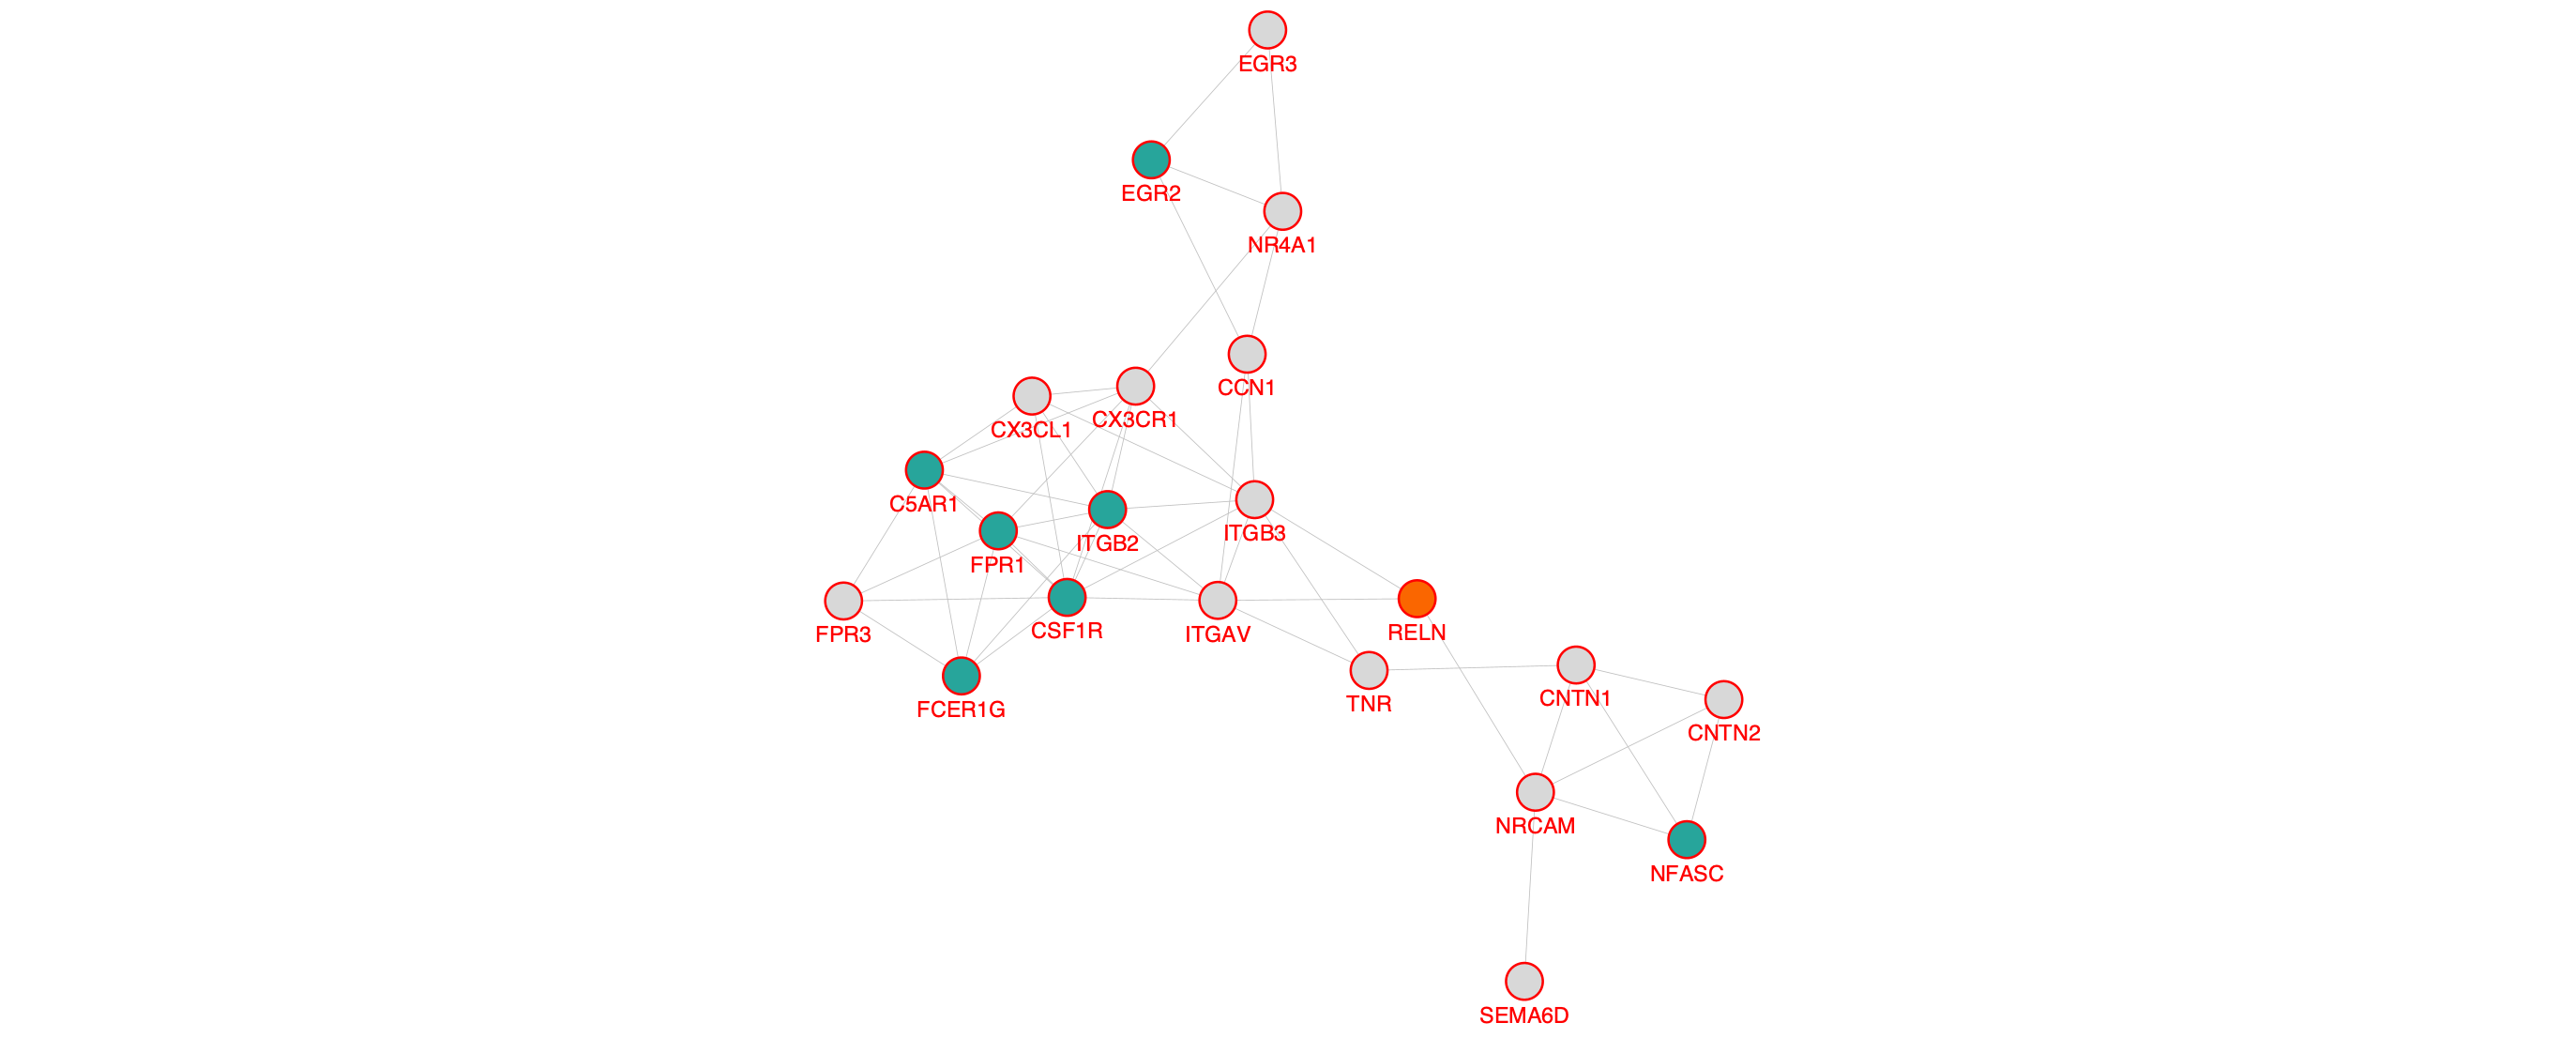

In [57]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0006935', # glutamate receptor signaling pathway
    disease_name='focal_epilepsy',
    cutoff=0.4,
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## ulcerative colitis

In [61]:
df_protein_category = pd.read_csv('../results/test_results/ulcerative_colitis/ulcerative_colitis_whole_prediction_results.tsv', sep='\t').sort_values(by='predicted_score', ascending=False).iloc[:500, :]
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='ulcerative_colitis_main_network',
    cutoff=0.7)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [63]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0006955,Immune response,6.030000e-13,24,1321,Process
1,GO:0002376,Immune system process,7.050000e-12,27,2121,Process
2,GO:0002429,Immune response-activating cell surface recept...,1.180000e-10,12,197,Process
3,GO:0050776,Regulation of immune response,3.090000e-10,18,844,Process
4,GO:0042554,Superoxide anion generation,5.580000e-10,7,22,Process
...,...,...,...,...,...,...
144,GO:0030097,Hemopoiesis,4.640000e-02,7,655,Process
145,GO:0030217,T cell differentiation,4.720000e-02,4,171,Process
146,GO:0051239,Regulation of multicellular organismal process,4.750000e-02,15,2749,Process
147,GO:0009617,Response to bacterium,4.910000e-02,7,663,Process


In [64]:
parse_enrichment_results(enrichment_results[1],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0006952,Defense response,9.630000e-21,29,1394,Process
1,GO:0006954,Inflammatory response,1.340000e-18,21,538,Process
2,GO:0051707,Response to other organism,2.100000e-17,26,1328,Process
3,GO:0009966,Regulation of signal transduction,3.080000e-16,32,2978,Process
4,GO:0002224,Toll-like receptor signaling pathway,2.710000e-15,11,61,Process
...,...,...,...,...,...,...
187,GO:0045779,Negative regulation of bone resorption,4.340000e-02,2,17,Process
188,GO:0022408,Negative regulation of cell-cell adhesion,4.370000e-02,4,194,Process
189,GO:0001934,Positive regulation of protein phosphorylation,4.540000e-02,7,747,Process
190,GO:0006919,Activation of cysteine-type endopeptidase acti...,4.590000e-02,3,84,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


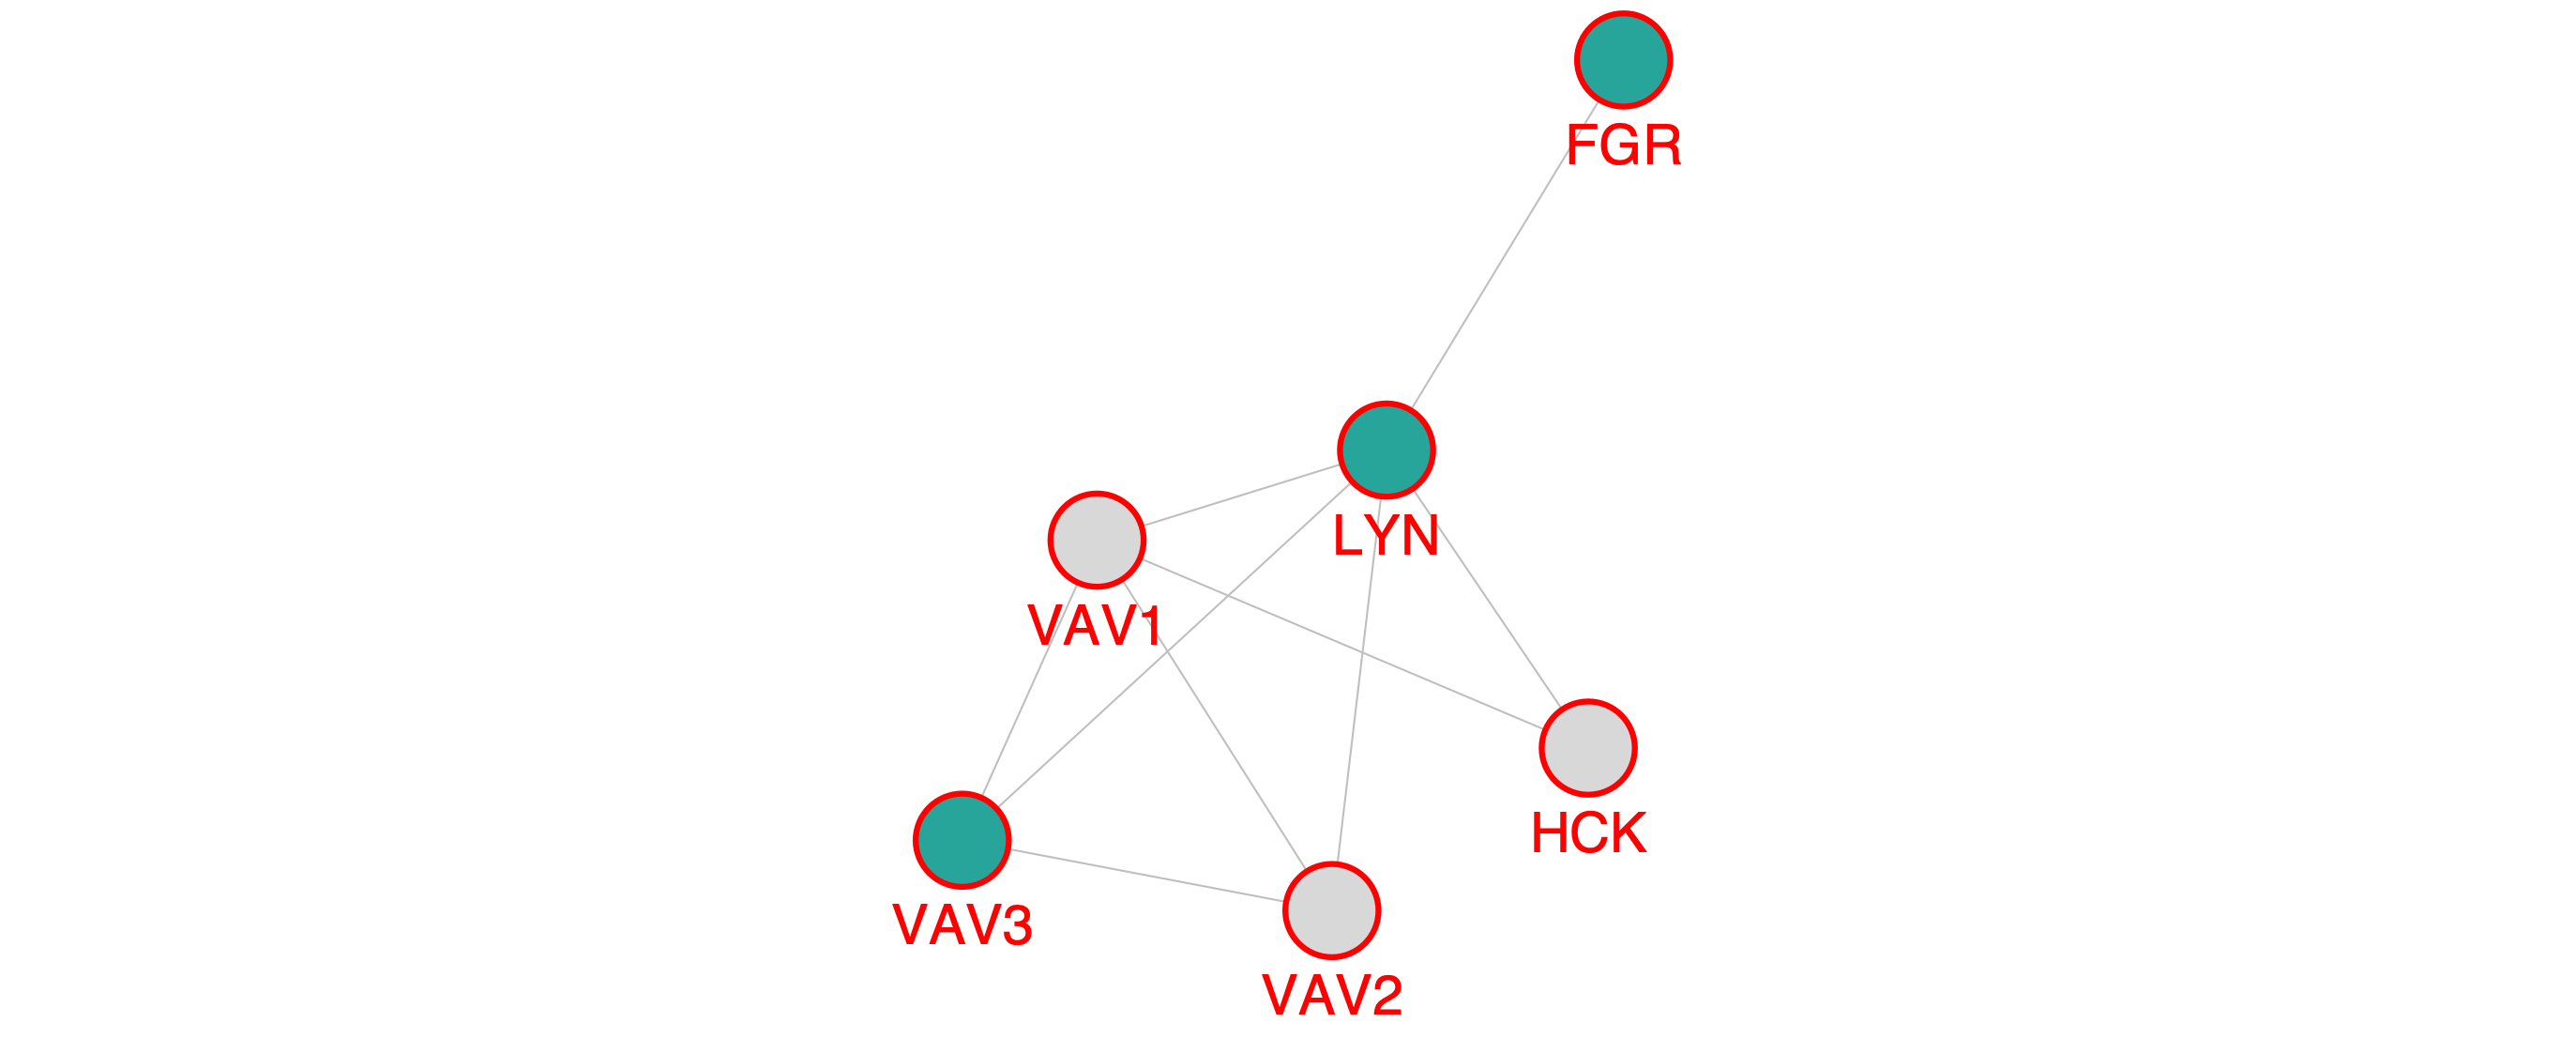

In [65]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0038096', # chemokine-mediated signaling pathway
    disease_name='ulcerative_colitis',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## colorectal cancer

In [47]:
df_protein_category = load_protein_data(
    predictions_file='../results/test_results/COADREAD/COADREAD_test_prediction_results.tsv',
    train_file='../data/train/COADREAD.mutations.intogen.txt',
    train_file_type='list',
    human_network_emb='../data/9606.node2vec64.h5',
    threshold=0.05
)
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='COADREAD_main_network',
    cutoff=0.9,
    networktype='full STRING network')
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [48]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0051896,Regulation of protein kinase B signaling,9.970000e-11,9,166,Process
1,GO:1902531,Regulation of intracellular signal transduction,1.320000e-10,15,1726,Process
2,GO:0051897,Positive regulation of protein kinase B signaling,1.600000e-10,8,113,Process
3,GO:1902533,Positive regulation of intracellular signal tr...,1.600000e-10,13,997,Process
4,GO:0042981,Regulation of apoptotic process,2.820000e-10,14,1462,Process
...,...,...,...,...,...,...
378,GO:0043154,Negative regulation of cysteine-type endopepti...,4.820000e-02,2,75,Process
380,GO:0071479,Cellular response to ionizing radiation,4.820000e-02,2,75,Process
376,GO:0034103,Regulation of tissue remodeling,4.820000e-02,2,75,Process
377,GO:0042130,Negative regulation of T cell proliferation,4.820000e-02,2,75,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


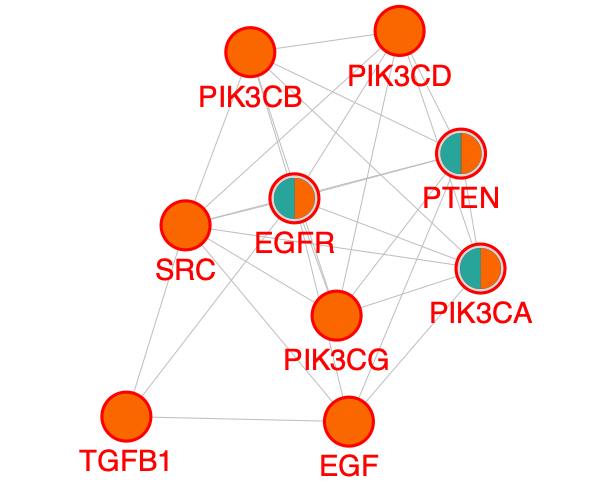

In [49]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0051896', # Regulation of protein kinase B signaling
    disease_name='COADREAD',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## MEL

In [52]:
df_protein_category = load_protein_data(
    predictions_file='../results/test_results/MEL/MEL_test_prediction_results.tsv',
    train_file='../data/train/MEL.mutations.intogen.txt',
    train_file_type='list',
    human_network_emb='../data/9606.node2vec64.h5',
    threshold=0.05
)
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='MEL_main_network',
    cutoff=0.7)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [53]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0042269,Regulation of natural killer cell mediated cyt...,7.480000e-09,6,47,Process
1,GO:0050776,Regulation of immune response,9.790000e-07,9,844,Process
2,GO:0002682,Regulation of immune system process,2.420000e-06,10,1438,Process
3,GO:0002831,Regulation of response to biotic stimulus,2.420000e-06,7,361,Process
4,GO:0002697,Regulation of immune effector process,3.040000e-06,7,383,Process
5,GO:0045954,Positive regulation of natural killer cell med...,5.560000e-06,4,27,Process
6,GO:0002768,Immune response-regulating cell surface recept...,5.990000e-06,6,228,Process
7,GO:0002228,Natural killer cell mediated immunity,9.650000e-06,4,35,Process
8,GO:0002699,Positive regulation of immune effector process,9.700000e-06,6,264,Process
9,GO:0001914,Regulation of T cell mediated cytotoxicity,1.280000e-05,4,39,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


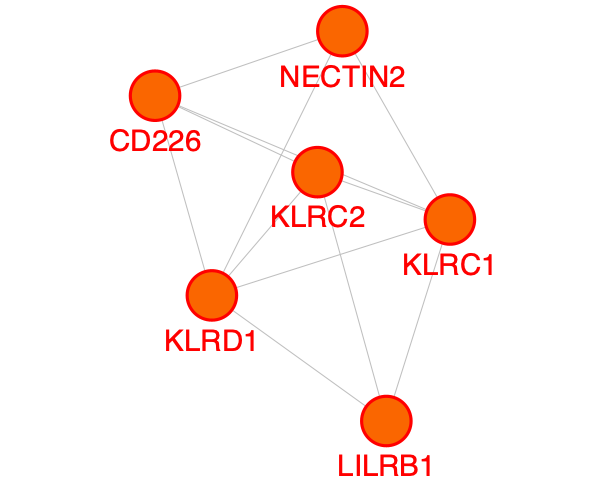

In [30]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0042269', # Regulation of natural killer cell mediated cytotoxicity
    disease_name='MEL',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## lymphoma


In [57]:
df_protein_category = load_protein_data(
    predictions_file='../results/test_results/DLBCLNOS/DLBCLNOS_test_prediction_results.tsv',
    train_file='../data/train/DLBCLNOS.mutations.intogen.txt',
    train_file_type='list',
    human_network_emb='../data/9606.node2vec64.h5',
    threshold=0.05
)
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='DLBCLNOS_main_network',
    cutoff=0.7)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [58]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0002682,Regulation of immune system process,1.160000e-29,41,1438,Process
1,GO:0002376,Immune system process,6.090000e-29,45,2121,Process
2,GO:0002694,Regulation of leukocyte activation,6.430000e-28,31,601,Process
3,GO:0006955,Immune response,2.850000e-27,38,1321,Process
4,GO:0051249,Regulation of lymphocyte activation,4.320000e-27,29,508,Process
...,...,...,...,...,...,...
177,GO:0002823,Negative regulation of adaptive immune respons...,4.730000e-02,3,57,Process
178,GO:0001771,Immunological synapse formation,4.900000e-02,2,12,Process
179,GO:0043030,Regulation of macrophage activation,4.900000e-02,3,58,Process
180,GO:0010941,Regulation of cell death,4.950000e-02,13,1651,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


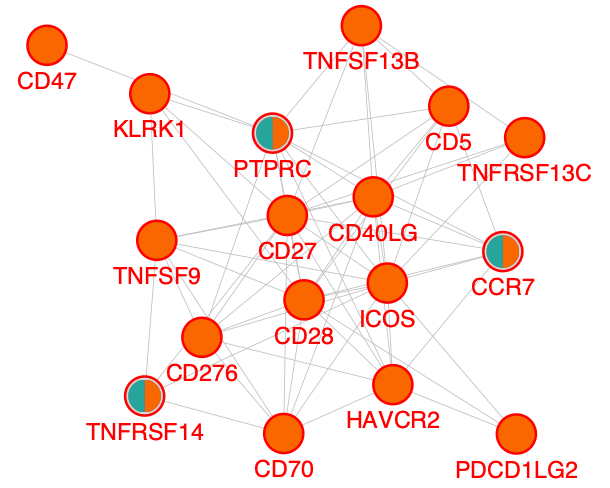

In [59]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0050870', # Positive regulation of T cell activation
    disease_name='DLBCLNOS',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()

## aneurysm

In [60]:
df_protein_category = load_protein_data(
    predictions_file='../results/test_results/aortic_aneurysm/aortic_aneurysm_test_prediction_results.tsv',
    train_file='../data/train/aortic_aneurysm.olink.tsv',
    train_file_type='list',
    human_network_emb='../data/9606.node2vec64.h5',
    threshold=0.05
)
# make network and cluster
suid = make_network(
    proteins=df_protein_category['protein'].tolist(),
    network_name='aortic_aneurysm_main_network',
    cutoff=0.7)
# cluster the network
cluster_result = network_cluster(suid, inflation_parameter=4)
cluster_proteins = [[node_dict['name'] for node_dict in cluster_result['clusters'][0]['nodes']]]
cluster_proteins.append([node_dict['name'] for node_dict in cluster_result['clusters'][1]['nodes']])
enrichment_results = [function_enrichment(cluster_proteins[0])]
enrichment_results.append(function_enrichment(cluster_proteins[1]))

In [61]:
parse_enrichment_results(enrichment_results[0],category='Process')

,term,description,fdr,num_genes,num_genes_background,category
0,GO:0032963,Collagen metabolic process,7.760000e-12,9,61,Process
1,GO:0030574,Collagen catabolic process,3.760000e-09,7,41,Process
2,GO:0010033,Response to organic substance,5.530000e-09,21,2692,Process
3,GO:0022617,Extracellular matrix disassembly,5.530000e-09,7,47,Process
4,GO:1901700,Response to oxygen-containing compound,1.150000e-08,17,1547,Process
...,...,...,...,...,...,...
158,GO:1902531,Regulation of intracellular signal transduction,4.150000e-02,9,1726,Process
159,GO:0001819,Positive regulation of cytokine production,4.420000e-02,5,482,Process
160,GO:0051130,Positive regulation of cellular component orga...,4.570000e-02,7,1049,Process
161,GO:2000026,Regulation of multicellular organismal develop...,4.630000e-02,8,1389,Process


/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/py4cytoscape/tables.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


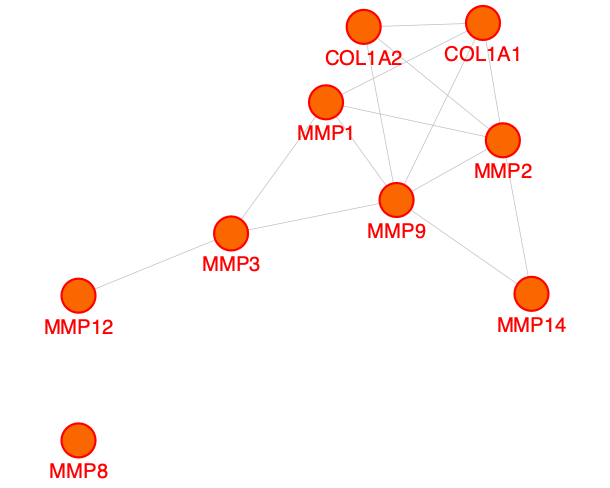

In [62]:
suid = make_network_plot(
    df_protein_category=df_protein_category,
    enrichment_results=enrichment_results[0],
    selected_term='GO:0032963', # Collagen metabolic process
    disease_name='aortic_aneurysm',
)
p4c.layout_network('force-directed', network=suid)
p4c.notebook_export_show_image()